In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [23]:
from datasets.carla import *
from datasets.nuscenes import *

from tools.utils import *
from tools.loss import *
import models.baseline as b
from models.backbones.midas.midas_net import *

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import importlib
importlib.reload(b)

In [ ]:
cd = CarlaDataset("../../data/carla/train", False, "all")

In [104]:
nd = compile_data("val", "mini", "../../data/nuscenes", "all",)

In [132]:
images, segs, depths, intrinsics, extrinsics, labels, oods = nd.dataset[0]

(694400,)
(693760,)
(693760,)
(693760,)
(693760,)


/data/bny220000/projects/sucam/datasets/nuscenes.py:269: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.Tensor(Quaternion(sensor_sample['rotation']).rotation_matrix),


(-0.5, 29.5, 13.5, -0.5)

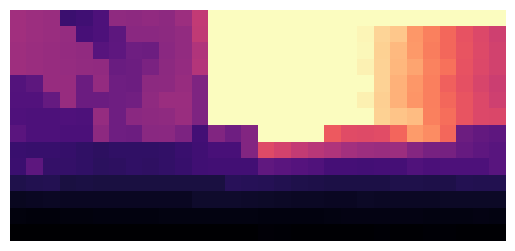

In [130]:
plt.imshow(depths[3], cmap="magma")
plt.axis("off")

In [ ]:
images, segs, depths, intrinsics, extrinsics, labels, oods = cd[0]
images = images[None].to(4)
segs = segs[None].to(4)
depths = depths[None].to(4)
intrinsics = intrinsics[None].to(4)
extrinsics = extrinsics[None].to(4)
labels = torch.tensor(labels[None]).to(4)
oods = torch.tensor(oods)[None].to(4)

In [ ]:
cdl = compile_data("train", "mini", "../../data/carla", "all")

In [ ]:
itd = iter(cdl)
next(itd)
next(itd)

images, segs, depths, intrinsics, extrinsics, labels, oods = next(iter(cdl))

In [ ]:
ba, c = depths.shape[:2]
downscaled = depths.reshape(ba, c, 14, 16, 30, 16).mean(dim=3).mean(dim=4)
dsm = depths.reshape(ba, c, 14, 16, 30, 16).amax(dim=3).amax(dim=4)

downscaled = downscaled.floor().long().clamp(min=0, max=40)
binned = torch.nn.functional.one_hot(downscaled, num_classes=41).permute(0, 1, 4, 2, 3)

In [ ]:
plt.imshow(binned[0, 0].argmax(dim=0).cpu())

In [ ]:
plt.imshow(depths[0, 1].cpu().clamp(min=0, max=40))

In [ ]:
model = b.Baseline([7], backbone='lss')
model.load(torch.load("../outputs/depth_sup_test/19.pt"))

In [ ]:
model_non = b.Baseline([7], backbone='lss')
model_non.load(torch.load("../outputs/lss_baseline/19.pt"))

In [ ]:
model_l = b.Baseline([7], backbone='lss')
model_l.load(torch.load("../outputs/sup_dep_LID/19.pt"))

In [ ]:
image, sg, pd = model(images, intrinsics, extrinsics)
plt.imshow(pd[0].softmax(dim=1).argmax(dim=0).detach().cpu().numpy())

In [ ]:
image, sg, pd = model_non(images, intrinsics, extrinsics)
plt.imshow(pd[0].softmax(dim=1).argmax(dim=0).detach().cpu().numpy())

In [ ]:
image, sg, pd = model_l(images, intrinsics, extrinsics)
plt.imshow(pd[0].softmax(dim=1).argmax(dim=0).detach().cpu().numpy())

In [ ]:
plt.imshow(depths[0, 0].log().detach().cpu().numpy())

In [ ]:
model.backbone.module.inter.shape

In [ ]:
plt.imshow(model.backbone.module.inter[0].sum(dim=0).detach().cpu().numpy())

In [ ]:
plt.imshow(model_non.backbone.module.inter[0].sum(dim=0).detach().cpu().numpy())

In [ ]:
plt.imshow((model_l.backbone.module.inter[0].mean(dim=0)).detach().cpu().numpy() )